# Lab 09: Shallow Neural Network for Wine Quality Prediction

**Lab Objective:** This notebook provides a solution for building and experimenting with a shallow neural network to predict the quality of red wine using the UCI Wine Quality dataset. You may use either PyTorch or TensorFlow for this implementation, but start-up code is provided for PyTorch and only sketched (at the end) for TensorFlow/Keras.

**Key Learning Points:**
1.  Data loading and preprocessing for neural networks.
2.  Defining a flexible neural network architecture in PyTorch or TensorFlow.
3.  Training a neural network, including:
    * Setting hyperparameters.
    * Using a validation set to monitor performance.
    * Implementing **early stopping** to prevent overfitting.
    * Implementing **automatic model saving** to keep the best model.
4.  Evaluating the model on a test set.
5.  Plotting and interpreting training and validation loss curves.
6.  Understanding how to experiment with network parameters (number of layers, number of nodes) and training parameters (learning rate, batch size).

**Dataset:** We will use the Red Wine Quality dataset from the UCI Machine Learning Repository. The goal is to predict the 'quality' score of the wine (an integer between 3 and 8) based on its physicochemical properties.

## 1. Setup: Import Libraries and Load Dataset

In [1]:
! python -m pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For better visualizations

# Scikit-learn for preprocessing and splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# For fetching UCI dataset
from ucimlrepo import fetch_ucirepo 

import time

# Set a random seed for reproducibility
SEED = 27
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Configure plots
plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style

In [2]:
# Fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# Data (as pandas dataframes) 
X_df = wine_quality.data.features 
y_df = wine_quality.data.targets 

# For this lab, we'll focus on the red wine dataset.
# The dataset combines red and white wine samples. We need to filter for red wines.
# According to the dataset description, the first 1599 instances are red wine.
df_red = pd.concat([X_df, y_df], axis=1).iloc[:1599]

print("Red Wine Dataset Shape:", df_red.shape)
df_red.head()

Red Wine Dataset Shape: (1599, 12)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 2. Data Exploration and Preprocessing

In [4]:
print("Dataset Information:")
df_red.info()

print("\nStatistical Summary:")
print(df_red.describe())

print("\nMissing values:")
print(df_red.isnull().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB

Statistical Summary:
       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    159

The dataset appears clean with no missing values. The target variable is 'quality'.

### 2.1. Define Features (X) and Target (y)

In [5]:
X = df_red.drop('quality', axis=1).values
y = df_red['quality'].values.astype(np.float32) # Ensure target is float for regression

# Reshape y to be a 2D array (N, 1) as PyTorch loss functions often expect this for regression targets
y = y.reshape(-1, 1)

print("Shape of features (X):", X.shape)
print("Shape of target (y):", y.shape)
print("\nUnique quality scores:", np.unique(df_red['quality']))

Shape of features (X): (1599, 11)
Shape of target (y): (1599, 1)

Unique quality scores: [3 4 5 6 7 8]


### 2.2. Train-Validation-Test Split
We'll split the data into training (70%), validation (15%), and test (15%) sets.

In [6]:
# First split: 70% train, 30% temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=df_red['quality'])

# Second split: 50% of temp for validation, 50% for test (results in 15% validation, 15% test of original)
# Stratify by y_temp if possible, but y_temp might have fewer unique values after first split, making stratification difficult.
# For simplicity, we might not stratify the second split if it causes issues, or use original quality for stratification if labels are sparse.
# For this dataset, quality scores are somewhat imbalanced, so stratification is good.
y_temp_quality_labels = np.round(y_temp).astype(int).flatten() # Use rounded quality for stratification if needed
unique_labels_temp, counts_temp = np.unique(y_temp_quality_labels, return_counts=True)
if np.any(counts_temp < 2) and len(y_temp_quality_labels) > 0: # Check if any class has less than 2 samples for stratification
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)
    print("Warning: Stratification skipped for val/test split due to sparse classes in temp set.")
else:
    if len(y_temp_quality_labels) > 0:
         X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp_quality_labels)
    else:
        # Handle empty y_temp if it occurs, though unlikely with test_size=0.3 and 1599 samples
        X_val, X_test, y_val, y_test = np.array([]), np.array([]), np.array([]), np.array([])
        print("Warning: y_temp is empty, val/test sets will be empty.")

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 1119 samples
Validation set size: 240 samples
Test set size: 240 samples


### 2.3. Feature Scaling
Neural networks often perform better when input features are on a similar scale. We'll use `StandardScaler`.

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("First 5 rows of scaled training data:\n", X_train_scaled[:5])

First 5 rows of scaled training data:
 [[-1.16160628  0.82234707 -1.34722836  0.821232    0.33815979  1.53451378
   0.24868936 -0.45613195  1.32423885  0.02542503  0.82061838]
 [-0.47008078  0.44117395 -0.36953706 -0.57414227 -0.24529185  1.91223506
   0.4318107  -0.93961068 -1.34994374 -1.50607777 -1.03951829]
 [ 0.74008884  1.3124268  -0.78119655  0.26308229 -0.11563593  1.34565314
   0.85909382  1.01006985 -0.04546443 -0.09238288 -0.01644312]
 [-0.29719941  0.55008055  1.07127119 -0.57414227  0.27333183 -0.16523196
   1.53053872 -0.33000706 -0.76292805 -0.21019078 -0.85350462]
 [-0.47008078 -0.04890578  0.65961169 -0.2252987  -0.59104097 -0.3540926
  -0.78899822 -1.04471475 -0.30636029 -0.09238288  1.28565255]]


### 2.4. Convert to Tensors and Create DataLoaders

In [108]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
BATCH_SIZE = 32 # You can experiment with this
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 35
Number of validation batches: 8
Number of test batches: 8


## 3. Neural Network Model Definition

Define a flexible shallow neural network. A shallow network typically has 1 or 2 hidden layers.
The `ShallowNet` class will allow us to specify:
- `input_size`: Number of input features.
- `hidden_sizes`: A list containing the number of neurons in each hidden layer, generally a power of 2 (e.g., `[64, 32]` for two hidden layers).
- `output_size`: Number of output neurons (1 for regression, as we are predicting a single quality score).

In [109]:
class ShallowNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        """
        Args:
            input_size (int): Number of input features.
            hidden_sizes (list of int): List where each element is the number of neurons in a hidden layer.
            output_size (int): Number of output neurons.
        """
        super(ShallowNet, self).__init__()
        
        layers = []
        current_size = input_size
        
        # Add hidden layers
        for hidden_size in hidden_sizes:
            #### Define your network structure here
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())
            ####
            current_size = hidden_size
            
        # Add output layer
        layers.append(nn.Linear(current_size, output_size))
        # For regression, no activation function is typically used on the final output layer,
        # or a linear activation (which is equivalent to no activation).
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """Forward pass through the network."""
        return self.network(x)

# Example: Instantiate the model
input_features = X_train_scaled.shape[1]
output_neurons = 1

# --- Experiment with hidden_layer_config --- #
hidden_layer_config = [64, 32] # Example: Two hidden layers with 64 and 32 neurons respectively
# hidden_layer_config = [128]    # Example: One hidden layer with 128 neurons
# hidden_layer_config = []       # Example: Linear regression (no hidden layers)

model = ShallowNet(input_size=input_features, 
                   hidden_sizes=hidden_layer_config, 
                   output_size=output_neurons)

print(model)

ShallowNet(
  (network): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


## 4. Training Configuration

Here, we define the hyperparameters for training, the loss function, and the optimizer.

In [110]:
# --- Experiment with these hyperparameters --- #
LEARNING_RATE = 0.001
NUM_EPOCHS = 200 # Max number of epochs
PATIENCE = 15    # For early stopping: how many epochs to wait for improvement

# Loss function for regression
criterion = nn.MSELoss() # Mean Squared Error Loss; Could also use some other regression loss like L1Loss or SmoothL1Loss

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # Move model to the selected device

print(f"Using device: {device}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Max Epochs: {NUM_EPOCHS}")
print(f"Early Stopping Patience: {PATIENCE}")
print(f"Batch Size: {BATCH_SIZE}")

Using device: cuda
Learning Rate: 0.001
Max Epochs: 200
Early Stopping Patience: 15
Batch Size: 32


## 5. Training Loop with Early Stopping and Model Saving

The training loop will:
1.  Iterate for a specified number of epochs.
2.  For each epoch:

    a.  Train the model on the training data (forward pass, loss calculation, backward pass, optimizer step).

    b.  Evaluate the model on the validation data.

    c.  Implement **Early Stopping**: If the validation loss does not improve for `PATIENCE` consecutive epochs, stop training.

    d.  Implement **Model Saving**: Save the model's state (weights) if the current epoch yields a better validation loss than previously seen. This ensures we keep the best performing model.

In [111]:
start_time = time.time()

train_losses = []
val_losses = []

best_val_loss = float('inf')
epochs_no_improve = 0
best_model_path = 'best_wine_quality_model.pth'

### This is the main part you need to implement for training the model ###

for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train() # Set model to training mode
    current_train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # Move data to device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        
        # Calculate loss
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        current_train_loss += loss.item() * batch_X.size(0) # Accumulate loss
    
    epoch_train_loss = current_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode
    current_val_loss = 0.0
    
    with torch.no_grad(): # Disable gradient calculations for validation
        for batch_X_val, batch_y_val in val_loader:
            # Move data to device
            batch_X_val = batch_X_val.to(device)
            batch_y_val = batch_y_val.to(device)
            
            # Forward pass/inference for validation
            val_outputs = model(batch_X_val)
            
            # Calculate validation loss
            val_loss = criterion(val_outputs, batch_y_val)
            
            
            current_val_loss += val_loss.item() * batch_X_val.size(0)
            
    epoch_val_loss = current_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    # Early Stopping and Model Saving Logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path) # Save the best model
        epochs_no_improve = 0
        print(f"Validation loss improved. Saving model to {best_model_path}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.4f}")
            break

print("\nTraining finished.")

end_time = time.time()
print(f"Elapsed time: {end_time - start_time:.2f}")

Epoch [1/200], Train Loss: 28.4251, Val Loss: 20.3914
Validation loss improved. Saving model to best_wine_quality_model.pth
Epoch [2/200], Train Loss: 11.3049, Val Loss: 4.5641
Validation loss improved. Saving model to best_wine_quality_model.pth
Epoch [3/200], Train Loss: 2.7728, Val Loss: 2.9016
Validation loss improved. Saving model to best_wine_quality_model.pth
Epoch [4/200], Train Loss: 2.0966, Val Loss: 2.4706
Validation loss improved. Saving model to best_wine_quality_model.pth
Epoch [5/200], Train Loss: 1.8522, Val Loss: 2.1977
Validation loss improved. Saving model to best_wine_quality_model.pth
Epoch [6/200], Train Loss: 1.6683, Val Loss: 1.9748
Validation loss improved. Saving model to best_wine_quality_model.pth
Epoch [7/200], Train Loss: 1.5089, Val Loss: 1.7925
Validation loss improved. Saving model to best_wine_quality_model.pth
Epoch [8/200], Train Loss: 1.3685, Val Loss: 1.6284
Validation loss improved. Saving model to best_wine_quality_model.pth
Epoch [9/200], Train 

## 6. Plotting Learning Curves

Learning curves (loss vs. epochs) help us understand if the model is overfitting, underfitting, or training well.
- **Underfitting:** Both training and validation loss are high and might not decrease much.
- **Overfitting:** Training loss is low, but validation loss is significantly higher and might even start increasing.
- **Good Fit:** Both training and validation loss are low and converge.

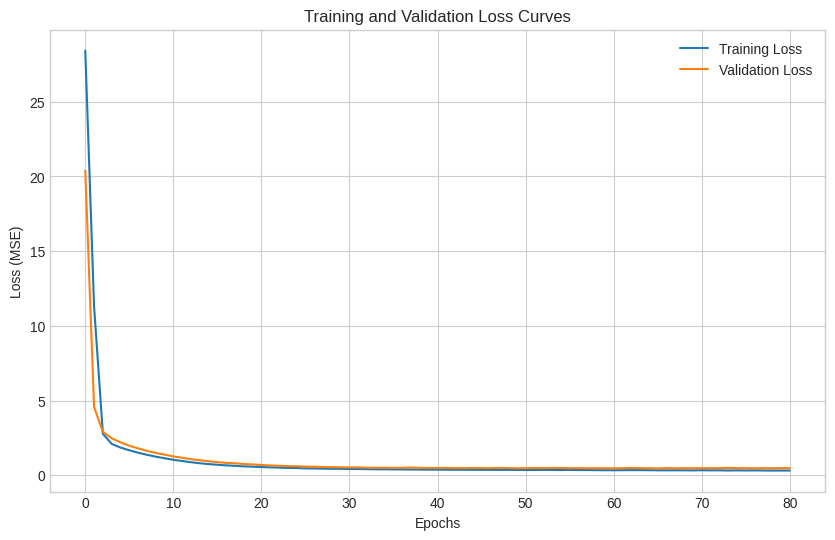

In [112]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

## 7. Model Evaluation on Test Set

Now, we load the best model (saved during training) and evaluate its performance on the unseen test set.

In [113]:
# Load the best model
best_model = ShallowNet(input_size=input_features, 
                        hidden_sizes=hidden_layer_config, 
                        output_size=output_neurons)
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device) # Move model to device
best_model.eval() # Set to evaluation mode

test_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_X_test, batch_y_test in test_loader:
        batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
        
        test_outputs = best_model(batch_X_test)
        loss = criterion(test_outputs, batch_y_test)
        test_loss += loss.item() * batch_X_test.size(0)
        
        all_predictions.extend(test_outputs.cpu().numpy())
        all_targets.extend(batch_y_test.cpu().numpy())

final_test_loss = test_loss / len(test_loader.dataset)
print(f"Test MSE Loss: {final_test_loss:.4f}")

# Calculate Mean Absolute Error (MAE) as another metric
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(all_targets, all_predictions)
print(f"Test MAE: {mae:.4f}")

# For wine quality, predictions are continuous. We can round them for comparison with discrete quality scores.
rounded_predictions = np.round(np.array(all_predictions))
accuracy_within_one = np.mean(np.abs(np.array(all_targets).flatten() - rounded_predictions.flatten()) <= 1)
exact_accuracy = np.mean(np.array(all_targets).flatten() == rounded_predictions.flatten())

print(f"Accuracy (predictions rounded, exact match): {exact_accuracy*100:.2f}%")
print(f"Accuracy (predictions rounded, within +/-1 quality point): {accuracy_within_one*100:.2f}%")

Test MSE Loss: 0.4142
Test MAE: 0.4978
Accuracy (predictions rounded, exact match): 60.42%
Accuracy (predictions rounded, within +/-1 quality point): 97.50%


### 7.1. Visualizing Predictions vs. Actual Values

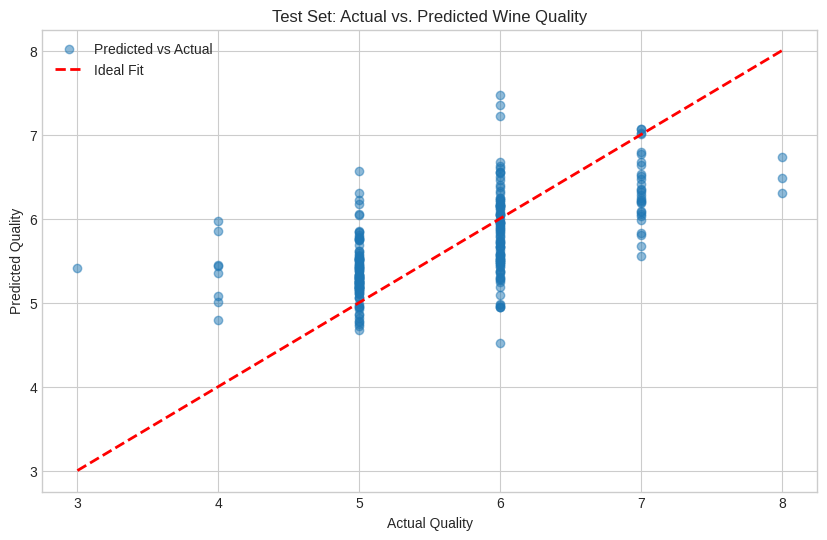

In [114]:
plt.figure(figsize=(10, 6))
plt.scatter(all_targets, all_predictions, alpha=0.5, label='Predicted vs Actual')
plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r--', lw=2, label='Ideal Fit') # Diagonal line
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')
plt.title('Test Set: Actual vs. Predicted Wine Quality')
plt.legend()
plt.grid(True)
plt.show()

## 8. Experimentation and Further Questions

Now it's your turn to experiment! Try modifying the following and observe the impact:

1.  **Network Architecture (`hidden_layer_config` in Section 3):**
    * Change the number of hidden layers (e.g., 1, 2, 3).
    * Change the number of neurons in each hidden layer (e.g., `[32]`, `[128]`, `[64, 64]`, `[128, 64, 32]`).
    * What happens if you use no hidden layers (`hidden_layer_config = []`)? This would be equivalent to linear regression.

2.  **Training Hyperparameters (Section 4):**
    * `LEARNING_RATE`: Try values like `0.01`, `0.0001`.
    * `BATCH_SIZE` (in Section 2.4): Try values like `16`, `64`, `128`.
    * `NUM_EPOCHS` and `PATIENCE`: How do these affect training time and the risk of overfitting/underfitting?

3.  **Optimizer (Section 4):**
    * Try other optimizers like `optim.SGD` (Stochastic Gradient Descent) or `optim.RMSprop`.
    * `optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)` (SGD with momentum often works well).

4.  **(Optional) Regularization:**
    * Uncomment the `nn.Dropout(0.2)` line in the `ShallowNet` class definition. Experiment with different dropout rates (e.g., 0.1, 0.3, 0.5).
    * Add L2 regularization (weight decay) to the optimizer: `optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)`.

**Questions to Consider and Answer Based on Your Experiments:**

* How does the complexity of the network (number of layers and neurons) affect its performance on the training, validation, and test sets? What about training time?
* How sensitive is the model's performance to the learning rate? What happens if it's too high or too low?
* How does batch size influence training speed and model performance/stability?
* Can you clearly observe overfitting or underfitting with certain configurations? How did early stopping help mitigate overfitting?
* What is the best test set performance (e.g., lowest MSE/MAE, highest accuracy within +/-1) you achieved, and what configuration led to it?
* How do the learning curves change with different configurations? Can you relate these changes to concepts like learning capacity, convergence speed, and generalization?

## Answers
**1. Network Architecture**

Changing the number of hidden layers slightly improved both training and validation loss (with 1 layer with 32 neurons each having a validation loss of 0.4485 while 3 layers with 32 neurons each had a validation loss of 0.4258). Both test MSE loss and test MAE increased as the number of layers increased (from 0.4091 test MSE loss and 0.4999 test MAE for 1 layer to 0.4330 test MSE loss and 0.5246 test MAE for 3 layers). Interestingly, accuracy for both exact match and match within +/-1 quality point were highest when using just 1 layer (63.33% and 97.5%, respectively), while it slightly decreased to 57.08% and 97.08% for 2 layers, and then increased again a little back to 57.92% and 97.08% for 3 layers, indicating that accuracy is highly dependent on the dataset rather than just the number of layers used. Finally, increasing the number of layers in fact decreased the training time, although this was likely due to the fact that using more layers triggered early stopping sooner (early stopping occurred after 120 epochs for layer 1, which ran for 4.38 seconds, but it occurred after 54 epochs for 3 layers and took only 2.47 seconds to run).

Using 1 layer with 128 neurons or 3 layers with 128 neurons each generally improved test MSE and MAE compared to smaller configurations, though exact match accuracy gains were minimal. Deeper networks like 3 layers with 64 neurons each sometimes led to slightly worse validation loss but trained faster due to earlier stopping. Overall, moderate-sized networks offered a strong trade-off between accuracy and training time.

Using no hidden layers took the longest to train (6.38 seconds) since there was no early stopping. Training and validation loss were both higher than when neurons were used (0.5350 and 0.5549, respectively). It also had the highest test MSE loss at 0.5181 and test MAE at 0.5426, and exact match accuracy was lower (55.83%) but +/- 1 accuracy was the same (97.08%). Overall, it seems like using no hidden layers led to the worst performance, although not by an extremely large margin.

**2. Training Hyperparameters**

A learning rate of 0.01 caused the model to converge quickly but with higher test loss and lower accuracy (MSE = 0.4719, 54.17% exact match), indicating unstable training. A very high learning rate (0.9) performed worst, with poor generalization (MSE = 0.6459, exact match = 40%). On the other hand, a very small learning rate of 0.0001 slowed training significantly (9.58s), and did not improve performance meaningfully compared to the default 0.001. This shows that the model is quite sensitive to learning rate, and too high or too low values both hurt performance.

A batch size of 16 led to slower training (2.60s) and worse test performance (MSE = 0.4395, exact match = 56.25%). Increasing to 64 improved both speed and performance (MSE = 0.3834, exact match = 62.5%). A batch size of 128 maintained decent accuracy but slightly worse MSE (0.4169). Larger batches appear to improve generalization and training efficiency, likely due to more stable gradient updates.

Changing the number of maximum epochs alone (e.g., 50, 100, 300) didn’t significantly improve performance due to early stopping. For instance, with 300 epochs, the model stopped at 64 epochs with good results (MSE = 0.3975, exact match = 63.75%). With only 50 epochs allowed, performance slightly worsened (MSE = 0.4423). Allowing a higher max epoch count is beneficial when paired with effective early stopping to prevent overfitting.

Smaller patience values (e.g., 1 or 5) resulted in early stopping before the model could sufficiently converge, leading to worse performance (MSE ≈ 0.5168 and 0.4236, exact match = 50% and 60.42%). Increasing patience to 10–20 led to better results (MSE ≈ 0.3970, exact match = 64.17%), while setting it too high (e.g., 50) allowed overfitting (higher val loss, test MSE = 0.4270). Therefore, patience around 10–20 strikes a good balance between training depth and overfitting prevention.

**3. Optimizer**

Compared to Adam, SGD had very similar results. The only difference was that it had just barely smaller test MSE loss and test MAE values, a slightly smaller validation loss but a larger training loss, and an exact match accuracy just barely higher than the exact accuracy using Adam (60.42 for SGD compared to 60.0% for Adam). The +/- 1 accuracy was 97.50% for both of them, and the training time was faster for SGD at 1.78 seconds compared to 2.30 seconds for Adam. RMS prop had a slightly higher test and validation loss than both Adam and SGD. Its test MSE loss was similar to both of the other optimizers as well (0.4045) while its test MAE was slightly lower than both around 0.4885. Its exact match accuracy was slightly higher (62.92%), although its +/-1 accuracy was a little lower (96.67%). RMS prop also had the longest runtime of 2.60 seconds.


**Answers to bullets 4-6 (questions in bullets 1-3 already answered in previous paragraph):**

Underfitting is observed with no hidden layers (high val loss = 0.5549 and MSE = 0.5181) and with a very low learning rate (0.0001), where the model fails to converge effectively. Overfitting is evident when validation loss stagnates or worsens while training loss continues to drop (e.g., learning rate = 0.9, where val loss = 0.6513). Early stopping was highly effective in all runs—it consistently prevented overfitting by halting training once validation loss stopped improving, resulting in better generalization and shorter training times.

The best test MSE of 0.3782 and MAE of 0.4814 were achieved with 1 hidden layer of 128 neurons, a learning rate of 0.001, batch size of 32, and early stopping at 104 epochs. The highest exact match accuracy (63.75%) was seen with 3 layers of 128 neurons each, and ±1 accuracy remained consistently high (97–98%) across nearly all configurations. Overall, since exact match accuracy is often the most important metric in classification-style tasks, I’d consider the model with 3 hidden layers of 128 neurons each to be the best. It achieved the highest exact match accuracy (63.75%) while maintaining strong test MSE (0.3934) and MAE (0.4834), making it a well-rounded and high-performing model.

Smaller networks and low learning rates resulted in slow convergence and higher training loss over time, indicating limited learning capacity. Larger networks (e.g., 3 layers with 128 neurons) converged quickly and achieved lower training loss, but without early stopping, they might have overfit. Learning rate also influenced convergence speed—0.01 was fast but unstable, while 0.0001 was slow and inefficient. In general, moderate configurations with proper early stopping balanced learning capacity and generalization well.

## 9. (Optional) TensorFlow/Keras Comparison Points

If you were to implement this using TensorFlow/Keras, the key components would be:

-   **Model Definition:** `tf.keras.Sequential` API with `tf.keras.layers.Dense` for fully connected layers.
    ```python
    # import tensorflow as tf
    # model = tf.keras.Sequential([
    #     tf.keras.layers.Dense(64, activation='relu', input_shape=(input_features,)),
    #     tf.keras.layers.Dense(32, activation='relu'),
    #     tf.keras.layers.Dense(1) # Output layer for regression
    # ])
    ```
-   **Compilation:** `model.compile()` to specify the optimizer, loss function, and metrics.
    ```python
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    #               loss='mean_squared_error',
    #               metrics=['mean_absolute_error'])
    ```
-   **Training:** `model.fit()` method, which also supports validation data and callbacks.
    ```python
    # from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    # early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
    # history = model.fit(X_train_scaled, y_train, 
    #                     epochs=100, 
    #                     batch_size=32, 
    #                     validation_data=(X_val_scaled, y_val),
    #                     callbacks=[early_stopping, model_checkpoint])
    ```
-   **Evaluation:** `model.evaluate()` on the test set.

This provides a conceptual comparison. The core ideas of defining layers, choosing a loss, an optimizer, and using callbacks for early stopping and model saving are similar across frameworks, though the specific APIs differ.